In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import sympy as sp


In [2]:
def kalman_step(A, C, Q, R, y, x, V):
    # INPUTS:
    # A - the system matrix
    # C - the observation matrix
    # Q - the system covariance
    # R - the observation covariance
    # y(:)   - the observation at time t
    # x(:) - E[X | y(:, 1:t-1)] prior mean
    # V(:,:) - Cov[X | y(:, 1:t-1)] prior covariance
    # OUTPUTS (where X is the hidden state being estimated)
    # xnew(:) =   E[ X | y(:, 1:t) ]
    # Vnew(:,:) = Var[ X(t) | y(:, 1:t) ]
    # VVnew(:,:) = Cov[ X(t), X(t-1) | y(:, 1:t) ]
    # loglik = log P(y(:,t) | y(:,1:t-1)) log-likelihood of innovation

    xpred = np.matmul(A, x)
    Vpred = np.matmul(np.matmul(A, V), A.transpose()) + Q

    e = y - np.matmul(C, xpred)  # error (innovation)
    S = np.matmul(np.matmul(C, Vpred), C.transpose()) + R
    ss = max(V.shape)
    loglik = gaussian_prob(e, np.zeros((1, e.size), dtype=np.float32), S, use_log=True)
    K = np.linalg.lstsq(S.transpose(), np.matmul(Vpred, C.transpose()).transpose(), rcond=None)[0].transpose()  # Kalman gain matrix
    # If there is no observation vector, set K = zeros(ss).
    xnew = xpred + np.matmul(K, e)
    Vnew = np.matmul((np.eye(ss) - np.matmul(K, C)), Vpred)
    VVnew = np.matmul(np.matmul((np.eye(ss) - np.matmul(K, C)), A), V)

    return xnew, Vnew, loglik, VVnew

def gaussian_prob(x, m, C, use_log=False):
    # Evaluate multivariate Gaussian density
    # p(i) = N(X(:,i), m, C) where C = covariance matrix and each COLUMN of x is a datavector
    # p = gaussian_prob(X, m, C, 1) returns log N(X(:,i), m, C) (to prevents underflow).
    # If X has size dxN, then p has size Nx1, where N = number of examples

    if m.size == 1:
        x = x.flatten().transpose()

    d, N = x.shape

    m = m.flatten()
    M = np.reshape(m * np.ones(m.shape, dtype=np.float32), x.shape)
    denom = (2 * math.pi)**(d/2) * np.sqrt(np.abs(np.linalg.det(C)))
    mahal = np.sum(np.linalg.solve(C.transpose(), (x - M)) * (x - M))   # Chris Bregler's trick

    if np.any(mahal < 0):
        print('Warning: mahal < 0 => C is not psd')

    if use_log:
        p = -0.5 * mahal - np.log(denom)
    else:
        p = np.divide(np.exp(-0.5 * mahal), (denom + 1e-20))

    return p

def sample_gauss(mu, sigma, n):
    # sample n samples from a given multivariate normal distribution
    return np.random.multivariate_normal(mu, sigma, n)

In [21]:
def RW(q, r):
    F = [
        [0,0],
        [0,0]
    ]
    L = [
        [1,0],
        [0,1]
    ]
    H = np.array([
        [1,0],
        [0,1]
    ], dtype=np.float32)

    R = r * np.array([
        [1,0],
        [0,1]
    ], dtype=np.float32)

    T = sp.symbols('T')
    F = sp.Matrix(F)
    L = sp.Matrix(L)
    Fi = np.array(sp.exp(F*T).subs(T,1), dtype=np.float32)
    Q = np.array(sp.integrate((Fi*L)*q*(Fi*L).T, (T, 0, T)).subs(T,1), dtype=np.float32)
    return Fi, Q, H, R


def NCV(q,r):
    F = np.array([
        [0,0,1,0],
        [0,0,0,1],
        [0,0,0,0],
        [0,0,0,0]
    ])
    L = np.array([
        [0,0],
        [0,0],
        [1,0],
        [0,1]
    ])
    H = np.array([
        [1,0,0,0],
        [0,1,0,0]
    ], dtype=np.float32)

    R = r * np.array([
        [1,0],
        [0,1]
    ], dtype=np.float32)

    T = sp.symbols('T')
    F = sp.Matrix(F)
    L = sp.Matrix(L)
    Fi = np.array(sp.exp(F*T).subs(T,1), dtype=np.float32)
    Q = np.array(sp.integrate((Fi*L)*q*(Fi*L).T, (T, 0, T)).subs(T,1), dtype=np.float32)
    return Fi, Q, H, R

def NCA(q,r):
    F = [
        [0,0,1,0,0,0],
        [0,0,0,1,0,0],
        [0,0,0,0,1,0],
        [0,0,0,0,0,1],
        [0,0,0,0,0,0],
        [0,0,0,0,0,0],
    ]
    L = [
        [0,0],
        [0,0],
        [0,0],
        [0,0],
        [1,0],
        [0,1]
    ]
    H = np.array([
        [1,0,0,0,0,0],
        [0,1,0,0,0,0]
    ], dtype=np.float32)

    R = r * np.array([
        [1,0],
        [0,1]
    ], dtype=np.float32)

    T = sp.symbols('T')
    F = sp.Matrix(F)
    L = sp.Matrix(L)
    Fi = np.array(sp.exp(F*T).subs(T,1), dtype=np.float32)
    Q = np.array(sp.integrate((Fi*L)*q*(Fi*L).T, (T, 0, T)).subs(T,1), dtype=np.float32)
    return Fi, Q, H, R

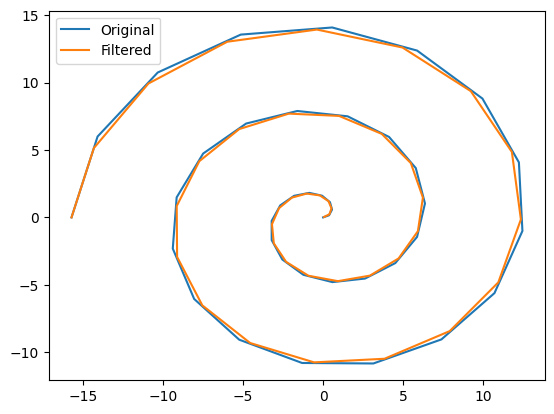

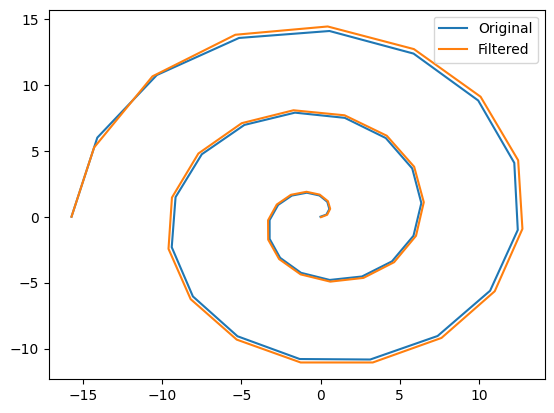

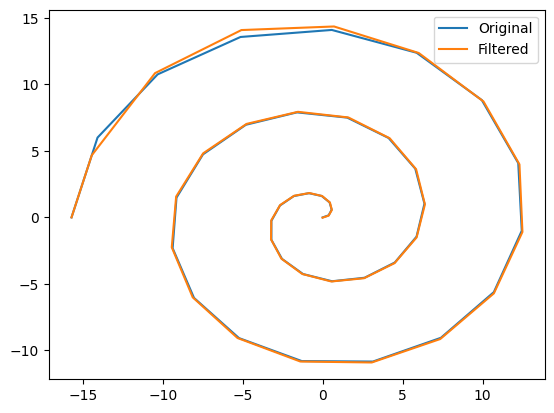

In [25]:
N = 40
v = np.linspace(5*math.pi, 0 , N)
x = np.cos(v)*v
y = np.sin(v)*v

algs = [RW, NCV, NCA]
algs = {"RW": RW, "NCV": NCV, "NCA": NCA}
params = [(100,1), (5,1), (1,1), (1,5), (1,100)]
for a in algs:
    q,r = params[1]
    A, Q, C, R = a(q,r)
    sx = np.zeros((x.size, 1), dtype=np.float32).flatten()
    sy = np.zeros((y.size, 1), dtype=np.float32).flatten()

    sx[0] = x[0]
    sy[0] = y[0]

    state = np.zeros((A.shape[0], 1), dtype=np.float32).flatten()
    state[0] = x[0]
    state[1] = y[0]
    covariance = np.eye(A.shape[0], dtype=np.float32)
    for j in range(1, x.size):
        state, covariance, _, _ = kalman_step(A, C, Q, R, np.reshape(np.array([x[j], y[j]]), (-1,1)), np.reshape(state, (-1,1)), covariance)
        sx[j] = state[0]
        sy[j] = state[1]
    plt.figure()
    plt.plot(x,y, label='Original', )
    plt.plot(sx, sy, label='Filtered')
    plt.legend()
    plt.show()


In [ ]:
sigmas = [0.1,0.5,1,1.5,3,4,5,6,10]
failures = [176,155,108,95,91,88,98,83,102]

plt.plot(sigmas, failures, label="Number of failures")
plt.xlabel("sigma")
plt.ylabel("failures")
plt.legend()

In [ ]:
factors = [0.8,0.9,1,1.1,1.2,1.4,1.6,2,2.5]
failures = [102,84,87,86,77,79,84,91,123]
plt.plot(factors, failures, label="Number of failures")
plt.xlabel("scale factor")
plt.ylabel("failures")
plt.legend()